In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Quick data visualization

First let's see how our images look like:

📂 Classes détectées : ['train', 'test']


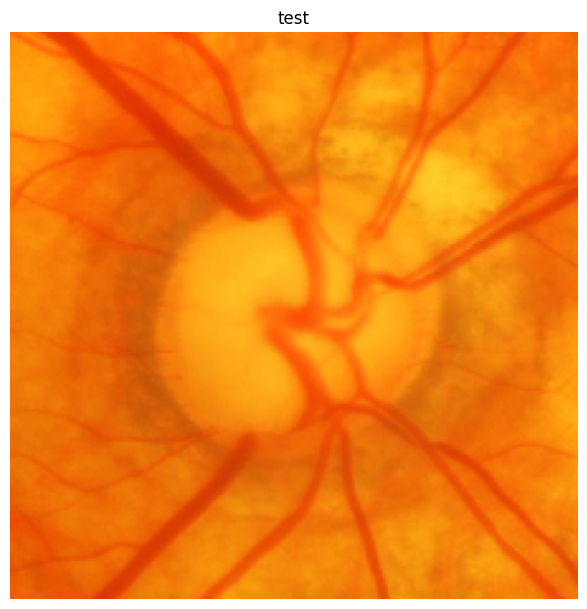

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img


base_path = "/content/drive/My Drive/acrima"


classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]


if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0


    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name)
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue


        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(224, 224))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


In [ ]:

for expression in os.listdir(base_path + "/train"):
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

326 Glaucoma images
239 Non Glaucoma images


In [ ]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "/content/drive/My Drive/acrima/train"

classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 224
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


Found 478 validated image filenames belonging to 2 classes.
📊 Nouvelle distribution des classes :
 class
Glaucoma        239
Non Glaucoma    239
Name: count, dtype: int64


<ipython-input-4-eaed69ba74d9>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


The image expressions in our training dataset are pretty balanced, except for the 'disgust' category.

Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


local_weights_path = "imagenet"
IMG_SHAPE = (224, 224, 3)


from tensorflow.keras.applications import ResNet50


baseModel = ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=local_weights_path
)


print("Number of layers in the base model: ", len(baseModel.layers))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  175


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
def create_model():

    for layer in baseModel.layers[:175]:
        layer.trainable = False
    for layer in baseModel.layers[175:]:
        layer.trainable = True


    model = models.Sequential([
        baseModel,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.6),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])



    model.compile(optimizer=Adam(learning_rate=5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
model=create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Fold 1/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.5493 - loss: 0.7476 - val_accuracy: 0.4688 - val_loss: 0.6971
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.5089 - loss: 0.7800 - val_accuracy: 0.4688 - val_loss: 0.6967
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.4671 - loss: 0.7701 - val_accuracy: 0.4688 - val_loss: 0.6945
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.4728 - loss: 0.7739 - val_accuracy: 0.4688 - val_loss: 0.6943
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.4825 - loss: 0.7549 - val_accuracy: 0.5312 - val_loss: 0.6934
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4584 - loss: 0.7688 - val_accuracy: 0.4688 - val_loss: 0.6946
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.5008 - loss: 0.7466 - val_accuracy: 0.4688 - val_loss: 0.6960
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.5215 - loss: 0.7155 - val_accur

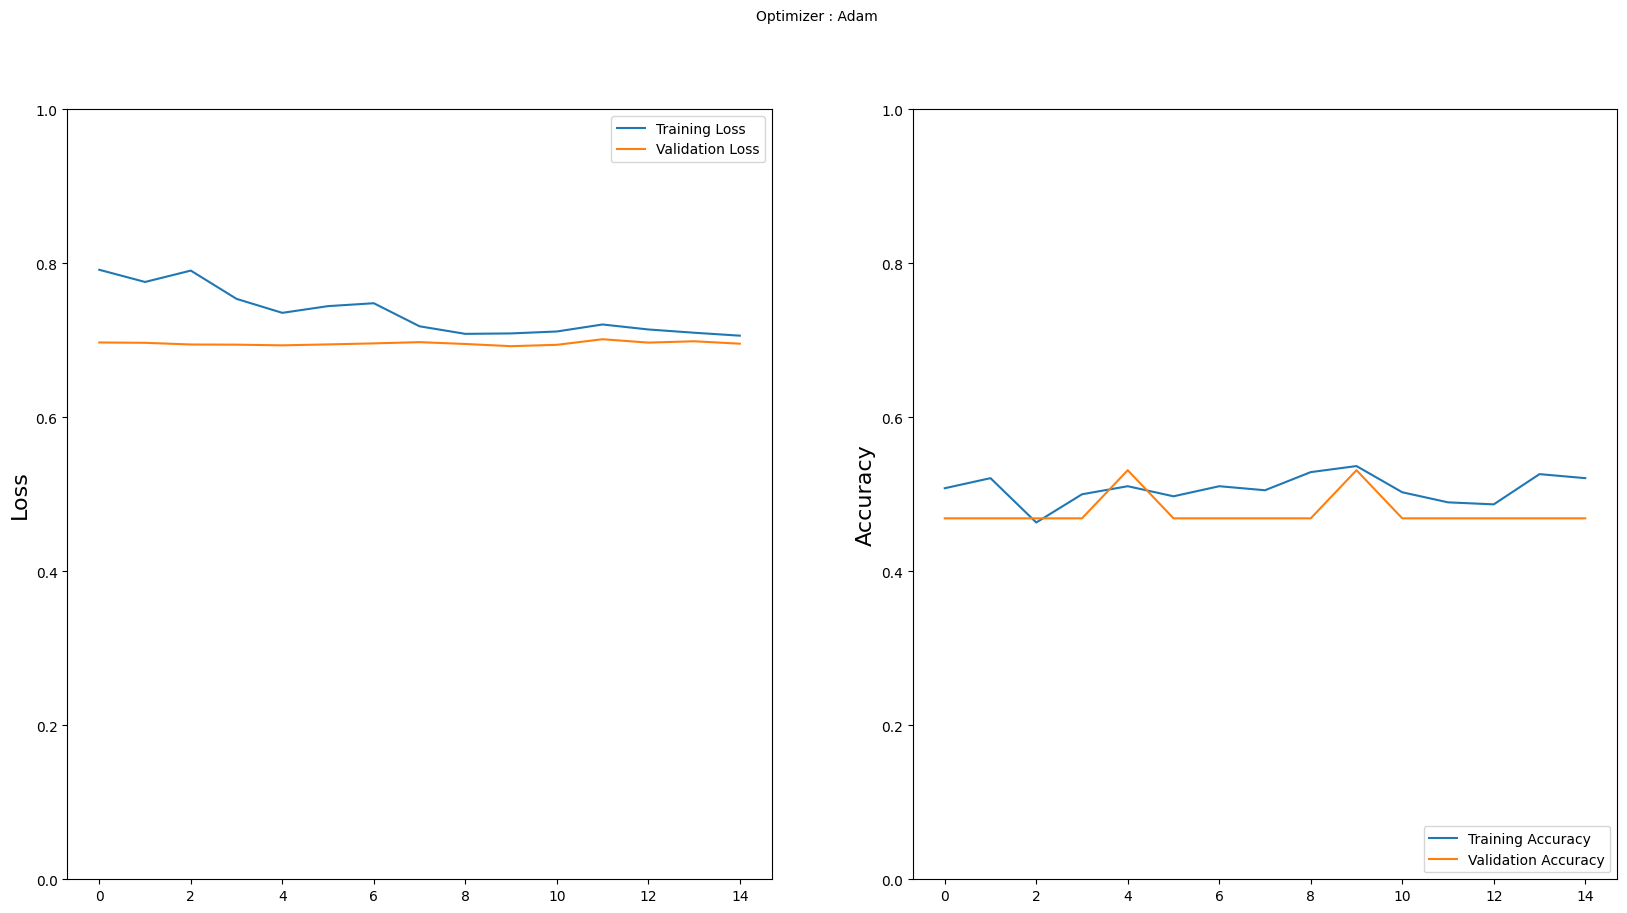

Fold 2/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 994ms/step - accuracy: 0.4835 - loss: 0.8788 - val_accuracy: 0.4583 - val_loss: 0.7226
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5078 - loss: 0.7482 - val_accuracy: 0.4583 - val_loss: 0.6971
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.4798 - loss: 0.7532 - val_accuracy: 0.3958 - val_loss: 0.6934
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.4986 - loss: 0.7618 - val_accuracy: 0.5417 - val_loss: 0.6922
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.4571 - loss: 0.7779 - val_accuracy: 0.3021 - val_loss: 0.6937
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.5173 - loss: 0.7191 - val_accuracy: 0.4583 - val_loss: 0.6952
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.5190 - loss: 0.6985 - val_accuracy: 0.4583 - val_loss: 0.6955
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4889 - loss: 0.7336 - val_acc

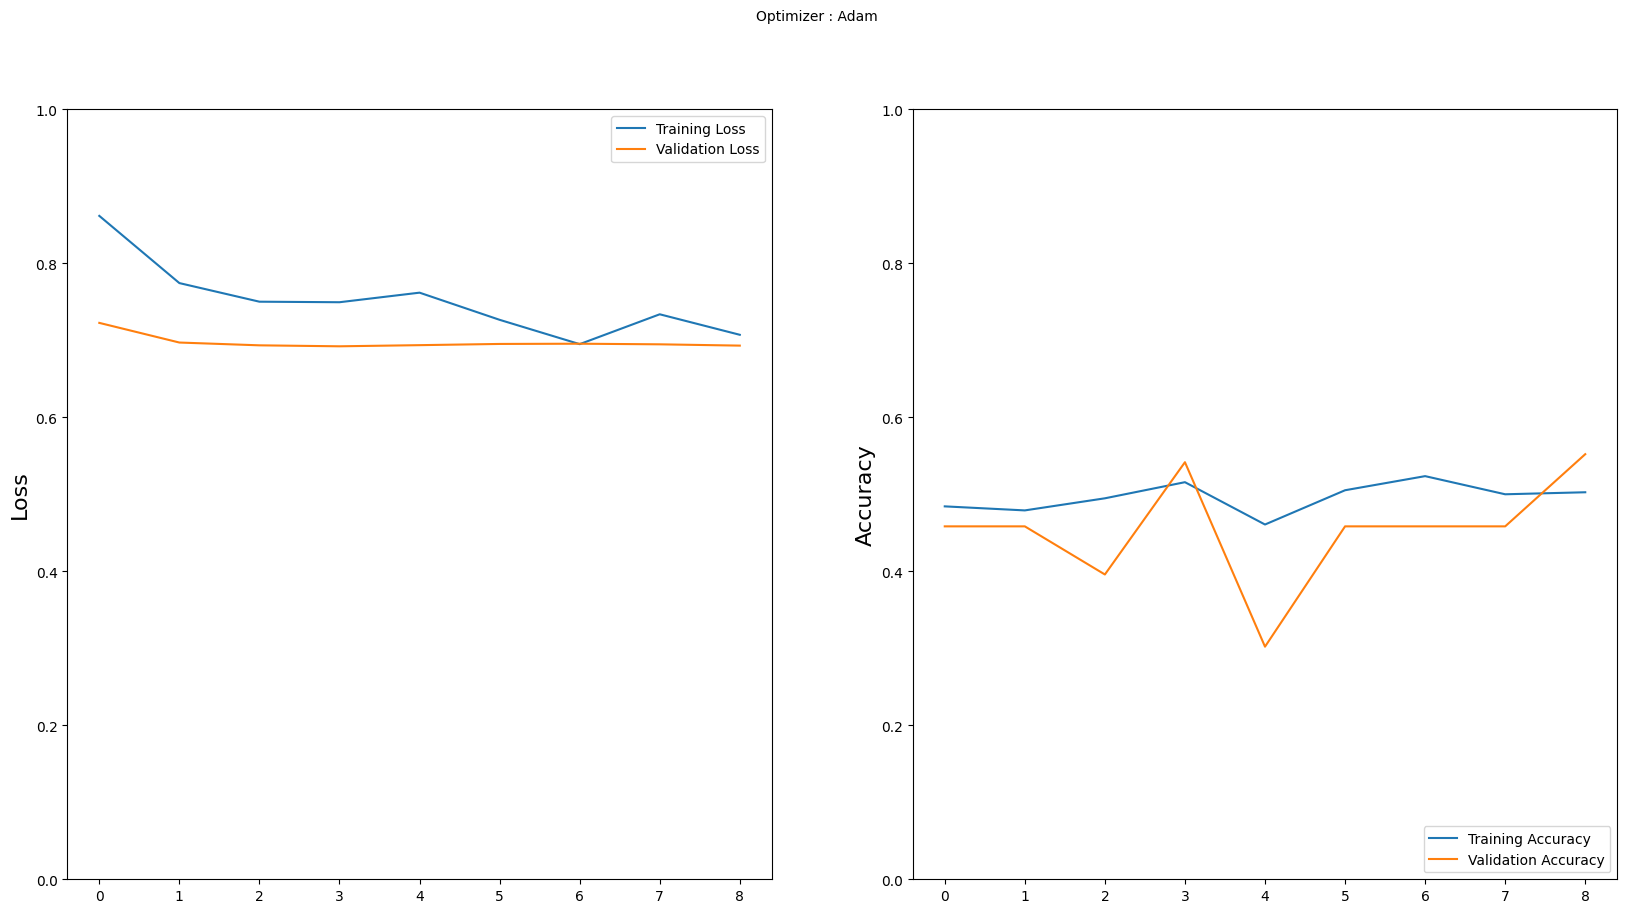

Fold 3/5
Found 382 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 981ms/step - accuracy: 0.5107 - loss: 0.9020 - val_accuracy: 0.4479 - val_loss: 0.7688
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.5117 - loss: 0.7428 - val_accuracy: 0.4479 - val_loss: 0.7028
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5286 - loss: 0.7227 - val_accuracy: 0.6562 - val_loss: 0.6919
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.4943 - loss: 0.7429 - val_accuracy: 0.7500 - val_loss: 0.6916
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.4812 - loss: 0.7304 - val_accuracy: 0.4479 - val_loss: 0.6952
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.4643 - loss: 0.7519 - val_accuracy: 0.4479 - val_loss: 0.6985
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.4920 - loss: 0.7254 - val_accuracy: 0.4479 - val_loss: 0.6946
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.4548 - loss: 0.7382 - val_acc

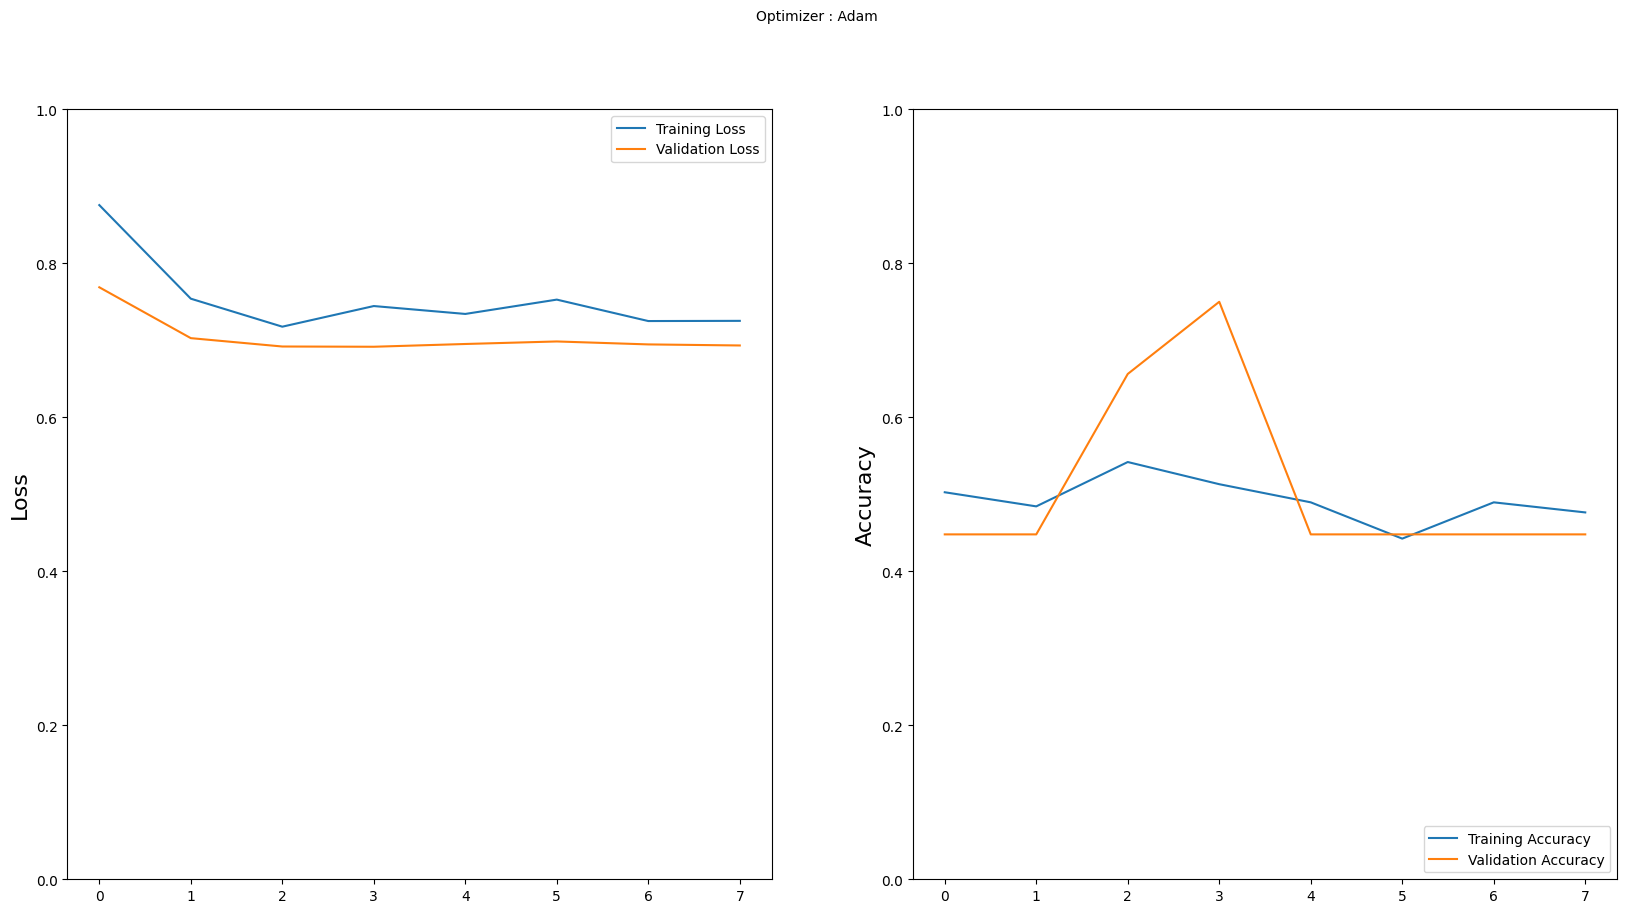

Fold 4/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4678 - loss: 0.7948 - val_accuracy: 0.4526 - val_loss: 0.7105
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.4523 - loss: 0.8112 - val_accuracy: 0.4526 - val_loss: 0.7033
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5342 - loss: 0.7285 - val_accuracy: 0.4526 - val_loss: 0.6972
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.4682 - loss: 0.7449 - val_accuracy: 0.4526 - val_loss: 0.6947
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.4696 - loss: 0.7395 - val_accuracy: 0.4526 - val_loss: 0.7011
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.5167 - loss: 0.7161 - val_accuracy: 0.4526 - val_loss: 0.6986
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.5491 - loss: 0.7176 - val_accuracy: 0.4526 - val_loss: 0.6975
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.5294 - loss: 0.7065 - val_accura

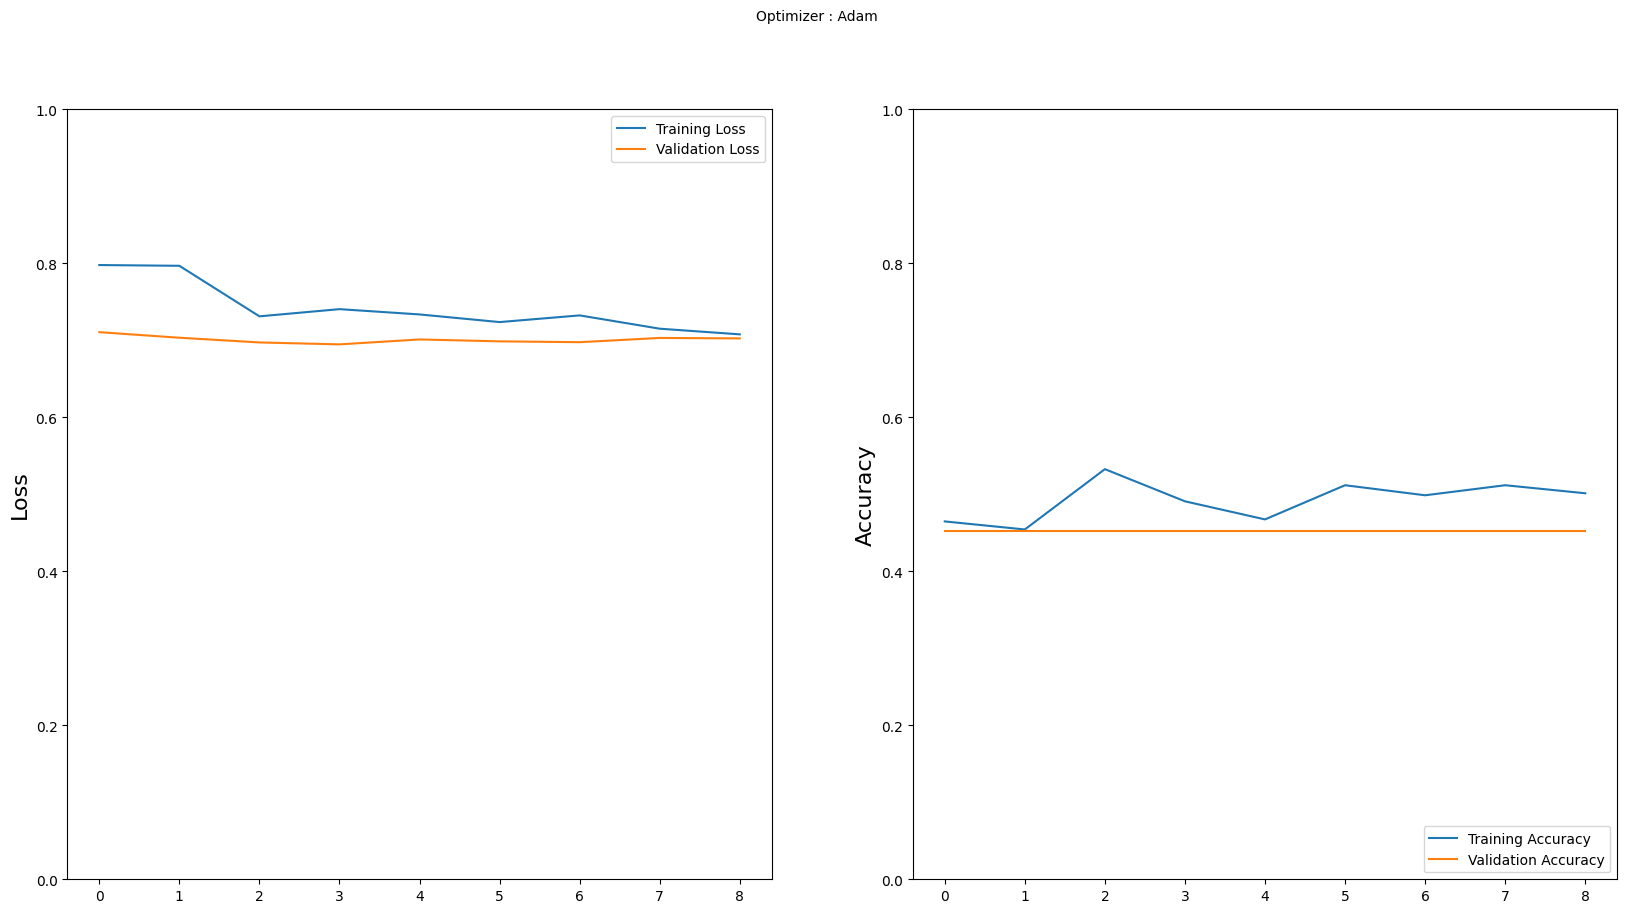

Fold 5/5
Found 383 validated image filenames belonging to 2 classes.
Found 95 validated image filenames belonging to 2 classes.


<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-8-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5429 - loss: 0.8203 - val_accuracy: 0.5158 - val_loss: 0.6960
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.4987 - loss: 0.8029 - val_accuracy: 0.4842 - val_loss: 0.6987
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.4682 - loss: 0.8303 - val_accuracy: 0.4842 - val_loss: 0.6943
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.4804 - loss: 0.7948 - val_accuracy: 0.4842 - val_loss: 0.6934
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.4804 - loss: 0.7727 - val_accuracy: 0.4842 - val_loss: 0.6930
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5454 - loss: 0.7032 - val_accuracy: 0.5895 - val_loss: 0.6931
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.5012 - loss: 0.7483 - val_accuracy: 0.4842 - val_loss: 0.6937
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.4930 - loss: 0.7409 - val_accura

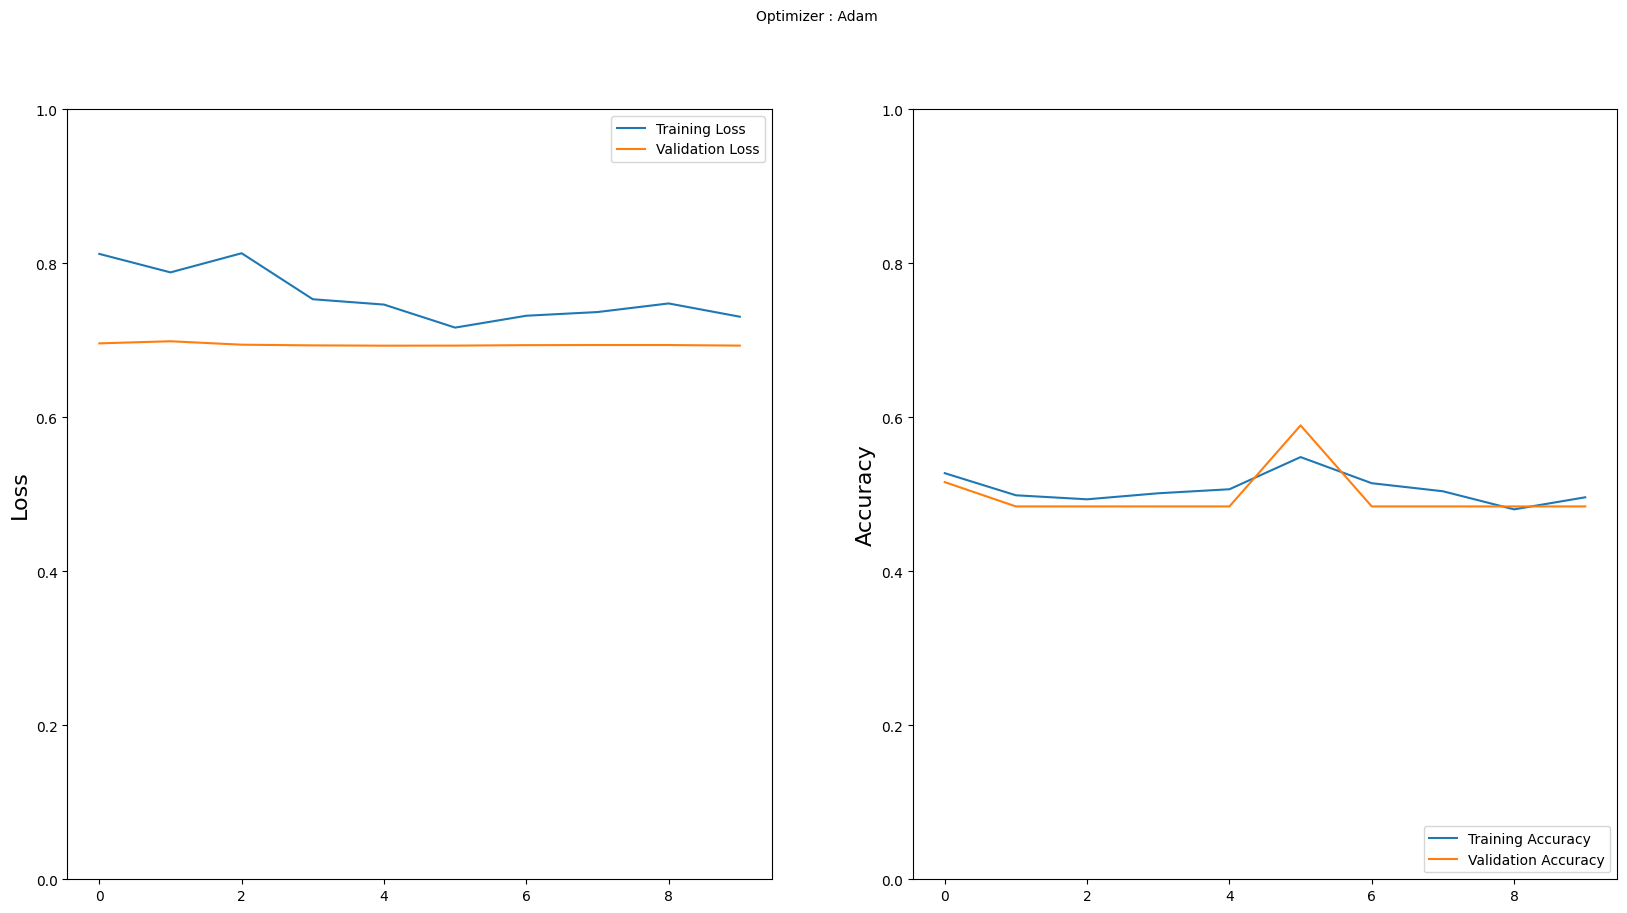

Moyenne des accuracies sur 5 folds: 0.5751


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)
batch_size = 32
epochs = 100
k_folds = 5
num_classes = 2

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []


image_dir = "/content/drive/My Drive/acrima/train"

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')


    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]

    train_generator = datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    model=create_model()




    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )


    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")


    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim([0, 1])


    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.ylim([0, 1])

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

import numpy

print(f'Moyenne des accuracies sur {k_folds} folds: {numpy.mean(fold_accuracies):.4f}')


In [ ]:
model.save('/content/drive/My Drive/glaucomeV16.hdf5')
print("SAVED")

SAVED


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/acrima/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='binary',
    shuffle=False
)


Found 140 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
✅ Accuracy: 50.00%


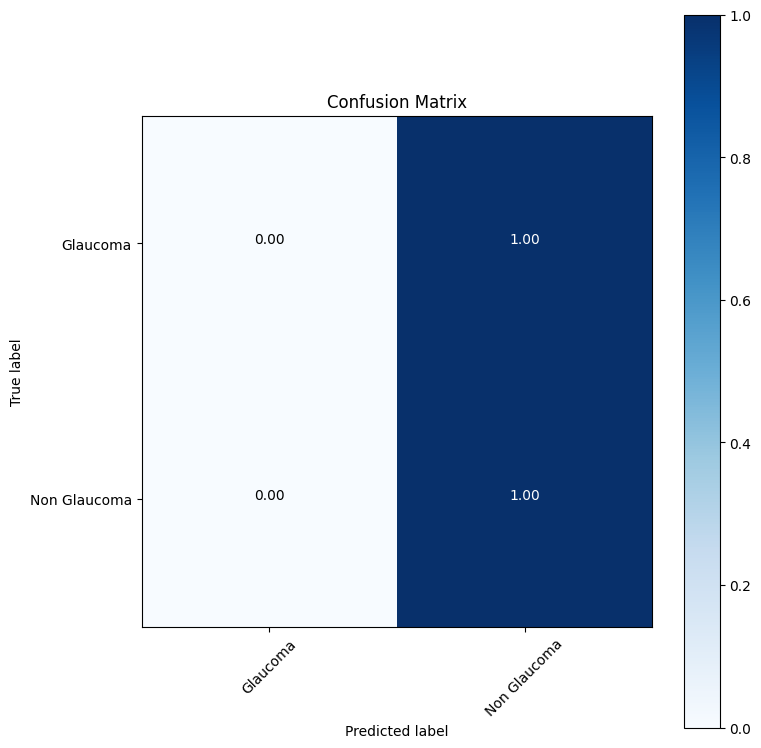

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# 🔹 Prédictions et vraies étiquettes
predictions = model.predict(test_generator, verbose=1)
y_pred = (predictions > 0.5).astype(int).flatten()

y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_true.extend(labels)

y_true = np.array(y_true).astype(int)

# 🔹 Matrice de confusion
cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
class_names = list(train_generator.class_indices.keys())

# 🔹 Affichage
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
